### Install easyocr

In [15]:
# First cell
!pip install easyocr

### Google Drive Connection

In [16]:
from google.colab import drive
import shutil
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import Libraries


In [17]:
# next cell
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import cv2
import numpy as np
import easyocr
import time
import csv
from datetime import datetime
import os
import re
import matplotlib.pyplot as plt

### Function to Capture Photo

In [18]:
# Next cell
# Function to take photo using JavaScript
def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
    async function takePhoto(quality) {
        const div = document.createElement('div');
        const video = document.createElement('video');
        const canvas = document.createElement('canvas');
        const button = document.createElement('button');
        button.textContent = 'Capture';
        document.body.appendChild(div);
        div.appendChild(video);
        div.appendChild(button);

        const stream = await navigator.mediaDevices.getUserMedia({video: true});
        video.srcObject = stream;
        await video.play();

        // Resize the canvas to match the video's dimensions
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;

        // Capture the photo
        await new Promise((resolve) => button.onclick = resolve);
        canvas.getContext('2d').drawImage(video, 0, 0);
        stream.getTracks().forEach(t => t.stop());

        const data = canvas.toDataURL('image/jpeg', quality);
        div.remove();
        return data;
    }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename


### Initialize EasyOCR Reader

In [19]:
# Next cell
# Initialize EasyOCR reader
reader = easyocr.Reader(['en'])

# Define CSV file for logging expiry dates
csv_file = 'expiry_dates.csv'

# Create the CSV file and write the header if it doesn't exist
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Serial Number', 'Expiry Date', 'Manufacturing Date', 'Time of Scan'])


### Functions to Find Expiry and Manufacturing Dates

In [20]:
# Function to extract expiry date
def find_expiry_date(detected_texts):
    expiry_keywords = ['exp', 'expiry', 'best before', 'use by', 'discard date', 'expiration date']
    date_pattern = r'(\d{1,2}[/-]\d{1,2}[/-]\d{2,4}|\d{1,2}\s\w{3,9}\s\d{4}|\w{3,9}\s\d{1,2},\s\d{4}|\d{4}[/-]\d{1,2}[/-]\d{1,2})'

    for text, coords in detected_texts:
        cleaned_text = re.sub(r'[^\w\s:/-]', '', text).lower()  # Clean unwanted characters

        # Check if any expiry-related keyword exists in the text
        if any(keyword in cleaned_text for keyword in expiry_keywords):
            match = re.search(date_pattern, text)
            if match:
                return match.group(0), coords  # Return the matched date and its coordinates
        else:
            # Even if no keyword, check for date pattern (since dates could appear alone)
            match = re.search(date_pattern, text)
            if match:
                return match.group(0), coords
    return None, None

# Function to extract manufacturing date
def find_manufacturing_date(detected_texts):
    mfg_keywords = ['mfg', 'manufactured', 'mfg date', 'manufacturing date', 'produced on', 'date of manufacture']
    date_pattern = r'(\d{1,2}[/-]\d{1,2}[/-]\d{2,4}|\d{1,2}\s\w{3,9}\s\d{4}|\w{3,9}\s\d{1,2},\s\d{4}|\d{4}[/-]\d{1,2}[/-]\d{1,2})'

    for text, coords in detected_texts:
        cleaned_text = re.sub(r'[^\w\s:/-]', '', text).lower()  # Clean unwanted characters

        # Check if any manufacturing-related keyword exists in the text
        if any(keyword in cleaned_text for keyword in mfg_keywords):
            match = re.search(date_pattern, text)
            if match:
                return match.group(0), coords  # Return the matched date and its coordinates
        else:
            # Even if no keyword, check for date pattern (since dates could appear alone)
            match = re.search(date_pattern, text)
            if match:
                return match.group(0), coords
    return None, None


### Function to Display Image with Annotations

In [21]:
# Next cell
def display_image_with_annotations(img, detected_texts):
    for text, coords in detected_texts:
        if isinstance(coords, list) and len(coords) == 4:  # Ensure coords is a valid list with 4 points
            try:
                # Draw a rectangle around the detected text
                top_left = coords[0]
                bottom_right = coords[2]

                cv2.rectangle(img, (int(top_left[0]), int(top_left[1])),
                              (int(bottom_right[0]), int(bottom_right[1])),
                              (0, 255, 0), 2)  # Green rectangle

                # Put the detected text in red color
                cv2.putText(img, text, (int(top_left[0]), int(top_left[1])-10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)  # Red color
            except IndexError:
                print(f"Invalid coordinates for text: {text}")
        else:
            print(f"Invalid coordinates for text: {text}")

    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')  # Hide axes
    plt.show()



### Process Images from Webcam

In [22]:
def process_images_from_webcam():
    image_list = []
    num_images = 3  # Number of times to capture and process images

    for i in range(num_images):
        print(f"Capturing image {i+1}...")

        # Capture an image from the webcam
        filename = take_photo(f'image_{i+1}.jpg')

        # Load the captured image using OpenCV
        img = cv2.imread(filename)

        # Perform OCR using easyocr
        result = reader.readtext(img)

        # Collect detected texts
        detected_texts = [(detection[1], detection[0]) for detection in result]

        # Debugging: Print detected texts and coordinates
        for text, coords in detected_texts:
            print(f"Detected Text: {text} at {coords}")

        # Find expiry and manufacturing dates
        detected_expiry = find_expiry_date(detected_texts)
        detected_manufacturing = find_manufacturing_date(detected_texts)

        # Print expiry and manufacturing date
        print(f"Image {i+1}:")
        print(f"Expiry Date: {detected_expiry if detected_expiry else 'Not found'}")
        print(f"Manufacturing Date: {detected_manufacturing if detected_manufacturing else 'Not found'}")

        # Log the expiry date into CSV file
        if detected_expiry:
            with open(csv_file, mode='a', newline='') as file:
                writer = csv.writer(file)
                time_of_scan = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
                # writer.writerow([i+1, detected_expiry, detected_manufacturing if detected_manufacturing else 'Not found', time_of_scan])
                expiry_date_str = detected_expiry[0] if detected_expiry else 'Not found'
                mfg_date_str = detected_manufacturing[0] if detected_manufacturing else 'Not found'
                writer.writerow([i+1, expiry_date_str, mfg_date_str, time_of_scan])


        # Display the image with annotations
        display_image_with_annotations(img, detected_texts)

        # Wait for 10 seconds before taking the next image
        time.sleep(10)

        # Store the image and its detected data
        image_list.append((img, detected_expiry, detected_manufacturing))

    print(f"\nProcessed {len(image_list)} images in total.")
    return image_list


### Start Image Capture and Processing Loop

Capturing image 1...


<IPython.core.display.Javascript object>

Detected Text: 477 at [[np.int32(189), np.int32(9)], [np.int32(217), np.int32(9)], [np.int32(217), np.int32(23)], [np.int32(189), np.int32(23)]]
Detected Text: Reg No. 3A 1412/35 at [[np.int32(196), np.int32(241)], [np.int32(439), np.int32(241)], [np.int32(439), np.int32(292)], [np.int32(196), np.int32(292)]]
Detected Text: Lot & Control Na at [[np.int32(196), np.int32(297)], [np.int32(342), np.int32(297)], [np.int32(342), np.int32(324)], [np.int32(196), np.int32(324)]]
Detected Text: 17572 at [[np.int32(358), np.int32(292)], [np.int32(426), np.int32(292)], [np.int32(426), np.int32(324)], [np.int32(358), np.int32(324)]]
Detected Text: Mfg Date at [[np.int32(198), np.int32(332)], [np.int32(278), np.int32(332)], [np.int32(278), np.int32(358)], [np.int32(198), np.int32(358)]]
Detected Text: 16 JAN 2021 at [[np.int32(362), np.int32(324)], [np.int32(498), np.int32(324)], [np.int32(498), np.int32(356)], [np.int32(362), np.int32(356)]]
Detected Text: Date at [[np.int32(235), np.int32(367)], [

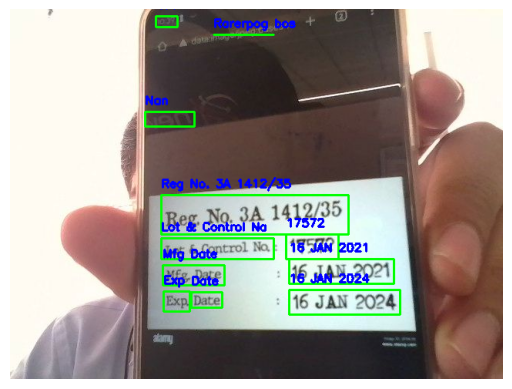

Capturing image 2...


<IPython.core.display.Javascript object>

KeyboardInterrupt: 

In [23]:
# Next cell
# Start the image capture and processing loop
images_with_text = process_images_from_webcam()

### Save File to Drive

In [24]:
folder_path = '/content/drive/MyDrive/Colab Notebooks'
os.makedirs(folder_path, exist_ok=True)
drive_path = os.path.join(folder_path, 'expiry_dates.csv')

In [25]:
# Check if the file already exists in Google Drive
if os.path.exists(drive_path):
    print("File already exists in Google Drive. Appending new data...")

    # Open existing file and the current session's file
    with open(csv_file, 'r') as current_file, open(drive_path, 'a') as drive_file:
        current_lines = current_file.readlines()[1:]  # skip header
        drive_file.writelines(current_lines)
else:
    print("File does not exist in Google Drive. Saving new file...")
    shutil.copy(csv_file, drive_path)  # Copy the file to Google Drive

print("✅ CSV file saved to Google Drive.")


File already exists in Google Drive. Appending new data...
✅ CSV file saved to Google Drive.


### View Saved CSV to cross check

In [31]:
import pandas as pd

# Load the saved CSV file from Google Drive
df = pd.read_csv(drive_path)

# Display the content
print("📋 Contents of expiry_dates.csv from Google Drive:")
display(df)


📋 Contents of expiry_dates.csv from Google Drive:


,Serial Number,Expiry Date,Manufacturing Date,Time of Scan
0,1,"('16 JAN 2021', [[np.int32(382), np.int32(280)...","('16 JAN 2021', [[np.int32(382), np.int32(280)...",2025-04-15 04:55:10
1,1,16 JAN 2021,16 JAN 2021,2025-04-15 05:09:29
